In [9]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.0 MB/s eta 0:00:00


In [10]:
import optuna 

In [16]:
import pandas as pd
import numpy as np
import math

import sklearn
import keras
import keras.backend as K
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM, CuDNNLSTM, MaxPooling1D, Conv1D, Flatten, BatchNormalization, Dropout, Input
from keras.models import Model
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from multiprocessing import cpu_count 
from joblib import Parallel 
from joblib import delayed 
from datetime import datetime



from sklearn.preprocessing import StandardScaler

from keras.utils import custom_object_scope
from keras.utils import get_custom_objects
from keras.models import load_model

from keras.layers import LSTM, RepeatVector, TimeDistributed, BatchNormalization, Dropout
from keras.initializers import GlorotUniform
from keras.activations import relu
from joblib import Parallel, delayed

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Multiply, Add
from tensorflow.keras.layers import Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_probability as tfp
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.optimizers import SGD


In [17]:

s7 = pd.read_csv('/content/drive/Shareddrives/1st Paper/s7.csv', header = 0, infer_datetime_format=True, index_col=['TIMESTAMP']).drop('Unnamed: 0', axis=1).reset_index()
df = s7[[
       'S7_Top_Temp_Avg', 'S7_Top_VWC_Avg'
       
       ]]



In [18]:


def split_dataset(data):
  """
    Splits the dataset into train and test sets.
    
    Args:
        data (array): The dataset to be split.
        
    Returns:
        train (array): The training dataset.
        test (array): The testing dataset.
  """
  # split into standard weeks
  train, test = data[0:288], data[288:576]
  #train, test = data[:-5817], data[-5817:-57] 6048
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/144))
  test = np.array(np.split( test , len(test )/144))
  return train, test

def to_supervised(train, n_input):
    """
    Converts the input data into a supervised learning format.
    
    Args:
        train (array): The training dataset.
        n_input (int): The number of input time steps.
        
    Returns:
        X (array): The input features for supervised learning.
        y (array): The target values for supervised learning.
    """
    # Flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # Step over the entire history one time step at a time
    for _ in range(len(data)):
        # Define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + 1
        # Ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end, 0]) 
        # Move along one time step
        in_start += 1
    return np.array(X), np.array(y)

def build_moe_model_with_autoencoder_cnn_attention(input_dim, output_dim, expert_hidden_sizes, expert_output_sizes,
                                     gating_hidden_sizes, num_experts, learning_rate, activation, kernel_initializer, dropout_rate,
                                     num_iterations=100):
    """
    Builds a Mixture of Experts (MoE) model with autoencoder, CNN and attention mechanisms.
    
    Args:
        input_dim (int): The dimension of input features.
        output_dim (int): The dimension of output features.
        expert_hidden_sizes (list): The hidden layer sizes for each expert.
        expert_output_sizes (list): The output layer sizes for each expert.
        gating_hidden_sizes (list): The hidden layer sizes for the gating network.
        num_experts (int): The number of experts in the model.
        learning_rate (float): The learning rate for the optimizer.
        activation (str): The activation function to be used in the hidden layers.
        kernel_initializer (str): The kernel initializer for the layers.
        dropout_rate (float): The dropout rate for dropout layers.
        num_iterations (int, optional): The number of iterations for training. Defaults to 100.
        
    Returns:
        moe_model (Model): The Mixture of Experts model.
        experts (list): The list of expert models.
        gating_model (Model): The gating network model.
    """
    experts = []
    for i in range(num_experts):
        if i == 0:  # Replace first expert with an autoencoder
            expert_input = Input(shape=(input_dim))
            expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
            expert_hidden = Dropout(dropout_rate)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for LSTM input
            expert_hidden, _, _ = LSTM(expert_hidden_sizes[i], return_state=True, kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))
        elif i == 1:  # Replace second expert with a Transformer expert
            expert_input = Input(shape=(input_dim))
            expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
            expert_hidden = Dropout(dropout_rate)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for Transformer input
            expert_hidden = MultiHeadAttention(num_heads=8, key_dim=expert_hidden_sizes[i])(expert_hidden, expert_hidden)
            expert_hidden = Flatten()(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))
        else:  # Replace third expert with a GRU-based model
            expert_input = Input(shape=(input_dim))
            expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
            expert_hidden = Dropout(dropout_rate)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for GRU input
            expert_hidden, _ = GRU(expert_hidden_sizes[i], return_state=True, kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))

    # Define the gating network
    gating_input = Input(shape=(input_dim,))
    gating_hidden = Dense(gating_hidden_sizes[0], activation='relu', kernel_initializer='he_normal')(gating_input)
    gating_hidden = Dropout(dropout_rate)(gating_hidden)
    gating_hidden = tf.expand_dims(gating_hidden, axis=1)  # Expand dimensions for LSTM input
    gating_hidden = Bidirectional(LSTM(gating_hidden_sizes[1], return_sequences=False, kernel_initializer='he_normal'))(gating_hidden)

    gating_output = Dense(num_experts + num_experts * 2, activation=None, kernel_initializer='he_normal')(gating_hidden)
    logits = gating_output[:, :num_experts]
    params = gating_output[:, num_experts:]
    params = tf.reshape(params, [-1, num_experts, 2])

    gating_distribution = tfp.distributions.MixtureSameFamily(
        mixture_distribution=tfp.distributions.Categorical(logits=logits),
        components_distribution=tfp.distributions.Normal(
            loc=params[..., 0],
            scale=tf.math.softplus(params[..., 1])
        )
    )

    gating_model = Model(inputs=gating_input, outputs=logits)

    # Define the MoE model
    inputs = Input(shape=(input_dim,))
    outputs = []
    for i in range(num_experts):
        expert_output = experts[i](inputs)
        if i == 0:  # For the autoencoder expert, append encoded representation to outputs list
            outputs.append(expert_output)
        else:
            outputs.append(experts[i](inputs))

    gating_output = gating_model(inputs)
    weighted_outputs = [tf.expand_dims(gating_output[:, i], axis=-1) * expert_output[:, :1] for i, expert_output in enumerate(outputs)]

    outputs = tf.reduce_sum(weighted_outputs, axis=0)

    moe_model = Model(inputs=inputs, outputs=outputs)

    return moe_model, experts, gating_model

# Define the loss function
def moe_loss(y_true, y_pred, gating_output):
    """
    Defines the loss function for the Mixture of Experts (MoE) model.
    
    Args:
        y_true (tensor): The true target values.
        y_pred (tensor): The predicted target values.
        gating_output (tensor): The output of the gating network.
        
    Returns:
        (tensor): The calculated MoE loss.
    """
    y_true = tf.cast(y_true, y_pred.dtype)
    expert_losses = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    expert_losses = tf.expand_dims(expert_losses, axis=-1)
    
    # Apply softmax to the logits to get probabilities
    gating_probabilities = tf.nn.softmax(gating_output, axis=-1)
    
    # Multiply expert_losses with the gating probabilities instead of logits
    gating_losses = tf.reduce_sum(tf.multiply(expert_losses, gating_probabilities), axis=-1)
    return tf.reduce_mean(gating_losses)

def scheduler(epoch, lr):
    """
    Custom learning rate scheduler.
    
    Args:
        epoch (int): The current epoch.
        lr (float): The current learning rate.
        
    Returns:
        (float): The updated learning rate.
    """
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def sliding_window_split(data, window_size, step_size):
    """
    Splits the input data into sliding windows of specified size and step size.
    
    Args:
        data (array): The input data to be split.
        window_size (int): The size of the sliding window.
        step_size (int): The step size for sliding the window.
        
    Returns:
        windowed_data (list): A list of arrays containing the data split into sliding windows.
    """
    windowed_data = []
    for i in range(0, len(data) - window_size, step_size):
        windowed_data.append(data[i:i + window_size])
    return windowed_data

def save_best_model_callback(study, trial):
    if study.best_trial.number == trial.number:
        # Save the best model
        best_model = trial.user_attrs['model']
        model_path = f'/content/drive/Shareddrives/1st Paper/best_MoE_model_s7_{trial.number}.h5'
        best_model.save(model_path)
        print(f"Best model saved to {model_path}")

In [19]:
def objective(trial, train_input, train_output, input_dim, output_dim):
    # Define the hyperparameters to optimize using Optuna
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid', 'tanh'])
    kernel_initializer = trial.suggest_categorical('kernel_initializer', ['glorot_normal', 'he_normal', None])

    window_size = 500
    step_size = 50

    # Define the sizes of the hidden layers for each expert
    expert_hidden_sizes = [16, 32, 64]

    # Define the sizes of the output layers for each expert
    expert_output_sizes = [144,144,144]

    # Define the sizes of the gating network hidden layers
    gating_hidden_sizes = [16, 8]

    # Define the size of the output layer of the gating network
    gating_output_size = num_experts

    # Define the number of training iterations for the EM algorithm
    num_iterations = 10

    # Load the training data
    train_data = np.array(df.head(10000))


    # Split the training data into input and output sequences
    train_input = train_data[:, :]
    print('train_input shape', train_input.shape)
    train_output = train_data[:, -1:]
    print('train_output shape', train_output.shape)


    # Normalize input data
    train_input = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)


    train_input_windows = sliding_window_split(train_input, window_size, step_size)
    train_output_windows = sliding_window_split(train_output, window_size, step_size)

    # Build and train the model using the hyperparameters
    moe_model, experts, gating_model = build_moe_model_with_autoencoder_cnn_attention(
        input_dim,
        output_dim,
        expert_hidden_sizes,
        expert_output_sizes,
        gating_hidden_sizes,
        num_experts,
        learning_rate,
        activation,
        kernel_initializer,
        dropout_rate)

    # Define the optimization algorithm
    optimizer = Adam(learning_rate=learning_rate)

    # Learning rate scheduler
    lr_scheduler = LearningRateScheduler(scheduler)

    # Train the MoE model with the EM algorithm
    iteration = 0
    while iteration < num_iterations:
        num_train_windows = int(0.8 * len(train_input_windows))
        for window_idx in range(len(train_input_windows)):

          # E step: Compute the responsibilities of each expert for each data point
          gating_output = tf.constant(gating_model.predict(train_input), dtype=tf.float64)
          gating_output /= tf.reduce_sum(gating_output, axis=-1, keepdims=True) + 1e-8  # Add a small epsilon value

          # M step: Update the parameters of each expert and the gating network
          for i in range(num_experts):
              expert_input = train_input
              expert_output = experts[i](expert_input)
              expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

              with tf.GradientTape() as tape:
                  # Watch the trainable variables of the expert model
                  tape.watch(experts[i].trainable_variables)

                  # Define the expert model and calculate the expert_loss
                  expert_output = experts[i](expert_input)
                  expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

              # Compute the gradients
              expert_gradient = tape.gradient(expert_loss, experts[i].trainable_variables)
              # Clip gradients for expert models
              expert_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in expert_gradient]

              # Update the variables
              optimizer.apply_gradients(zip(expert_gradient, experts[i].trainable_variables))
          
          current_learning_rate = scheduler(iteration, optimizer.learning_rate.numpy())
          optimizer.learning_rate.assign(current_learning_rate)

          gating_input = train_input

          with tf.GradientTape() as tape:
              # Watch the trainable variables of the gating model
              tape.watch(gating_model.trainable_variables)

              # Define the gating model and calculate the gating_loss
              gating_output = gating_model(gating_input)
              gating_loss = moe_loss(tf.constant(train_output, dtype=tf.float32), moe_model(train_input), gating_output)


          # Compute the gradients
          gating_gradient = tape.gradient(gating_loss, gating_model.trainable_variables)
          # Clip gradients for the gating model
          gating_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gating_gradient]

          # Update the variables
          optimizer.apply_gradients(zip(gating_gradient, gating_model.trainable_variables))

          # Evaluate the performance of the MoE model on the training set
          if window_idx < num_train_windows:
            train_loss = moe_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]), gating_model.predict(train_input_windows[window_idx]))
            print(f'Iteration {iteration + 1}, Training window {window_idx + 1}: Training loss = {train_loss:.6f}')
          else:
            val_loss = moe_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]), gating_model.predict(train_input_windows[window_idx]))
            print(f'Iteration {iteration + 1}, Validation window {window_idx - num_train_windows + 1}: Validation loss = {val_loss:.6f}')

        # Stop training if the learning rate becomes too small
        if current_learning_rate < 1e-6:
            print('Learning rate dropped below 1e-6 after iteration %d' % iteration)
            break

        iteration += 1
    trial.set_user_attr('model', moe_model)
    return train_loss


In [15]:
from functools import partial

# Load the training data
train_data = np.array(df.head(10000))


# Split the training data into input and output sequences
train_input = train_data[:, :]
print('train_input shape', train_input.shape)
train_output = train_data[:, -1:]
print('train_output shape', train_output.shape)


# Normalize input data
train_input = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)

input_dim = df.shape[1]
output_dim = 1

# Define the number of experts
num_experts = 3
objective_with_args = partial(objective, train_input=train_input, train_output=train_output, input_dim=input_dim, output_dim=output_dim)
study = optuna.create_study(direction="minimize")
study.optimize(objective_with_args, n_trials=5, callbacks=[save_best_model_callback])



[I 2023-05-12 12:53:30,793] A new study created in memory with name: no-name-f45e1a73-e772-4442-9d71-e3caa85c7a23


train_input shape (10000, 2)
train_output shape (10000, 1)
train_input shape (10000, 2)
train_output shape (10000, 1)


<ipython-input-14-5fdfc2a2915e>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-14-5fdfc2a2915e>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Streaming output truncated to the last 5000 lines.
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 81: Training loss = 0.126149
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 82: Training loss = 0.124532
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 83: Training loss = 0.123704
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 84: Training loss = 0.142877
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 85: Training loss = 0.147057
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 86: Training loss = 0.143846
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 87: Training loss = 0.136338
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 88: Training loss = 0.133982
16/16 [==============================] - 0s 2ms/step
Iteratio

[I 2023-05-12 13:29:20,570] Trial 0 finished with value: 0.012446795590221882 and parameters: {'dropout_rate': 0.275539462992651, 'learning_rate': 0.000316073143182179, 'activation': 'sigmoid', 'kernel_initializer': 'glorot_normal'}. Best is trial 0 with value: 0.012446795590221882.


Streaming output truncated to the last 5000 lines.
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 81: Training loss = 59.891407
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 82: Training loss = 64.567467
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 83: Training loss = 61.886841
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 84: Training loss = 76.608017
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 85: Training loss = 76.907768
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 86: Training loss = 71.757660
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 87: Training loss = 64.168869
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 88: Training loss = 65.964294
16/16 [==============================] - 0s 2ms/step


[I 2023-05-12 14:04:56,251] Trial 1 finished with value: 4.384428977966309 and parameters: {'dropout_rate': 0.3981308274917617, 'learning_rate': 1.834461570466339e-05, 'activation': 'relu', 'kernel_initializer': 'glorot_normal'}. Best is trial 0 with value: 0.012446795590221882.


Streaming output truncated to the last 5000 lines.
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 81: Training loss = 0.038790
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 82: Training loss = 0.153294
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 83: Training loss = 0.098859
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 84: Training loss = 0.139477
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 85: Training loss = 0.155257
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 86: Training loss = 0.123013
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 87: Training loss = 0.025076
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 88: Training loss = 0.070969
16/16 [==============================] - 0s 2ms/step
Iteratio

[I 2023-05-12 14:41:17,420] Trial 2 finished with value: 0.013549646362662315 and parameters: {'dropout_rate': 0.1299633384563581, 'learning_rate': 0.006175814202722198, 'activation': 'relu', 'kernel_initializer': None}. Best is trial 0 with value: 0.012446795590221882.


Streaming output truncated to the last 5000 lines.
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 81: Training loss = 0.213486
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 82: Training loss = 0.181745
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 83: Training loss = 0.193119
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 84: Training loss = 0.380986
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 85: Training loss = 0.594983
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 86: Training loss = 0.181072
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 87: Training loss = 0.123047
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 88: Training loss = 0.115247
16/16 [==============================] - 0s 2ms/step
Iteratio

[I 2023-05-12 15:17:33,653] Trial 3 finished with value: 0.01792789436876774 and parameters: {'dropout_rate': 0.301192480471231, 'learning_rate': 0.004311629726819231, 'activation': 'sigmoid', 'kernel_initializer': 'glorot_normal'}. Best is trial 0 with value: 0.012446795590221882.


Streaming output truncated to the last 5000 lines.
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 81: Training loss = 10.779925
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 82: Training loss = 11.398190
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 83: Training loss = 11.508821
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 84: Training loss = 11.401955
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 85: Training loss = 11.030725
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 86: Training loss = 11.502623
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 87: Training loss = 11.168097
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 88: Training loss = 10.989674
16/16 [==============================] - 0s 2ms/step


[I 2023-05-12 15:54:14,960] Trial 4 finished with value: 0.37396958470344543 and parameters: {'dropout_rate': 0.3561701746135253, 'learning_rate': 5.540035436693361e-05, 'activation': 'relu', 'kernel_initializer': 'he_normal'}. Best is trial 0 with value: 0.012446795590221882.


63/63 [==============================] - 1s 3ms/step
Model performance on test set: MAE=2.364701614952255, MSE=11.054822472433939


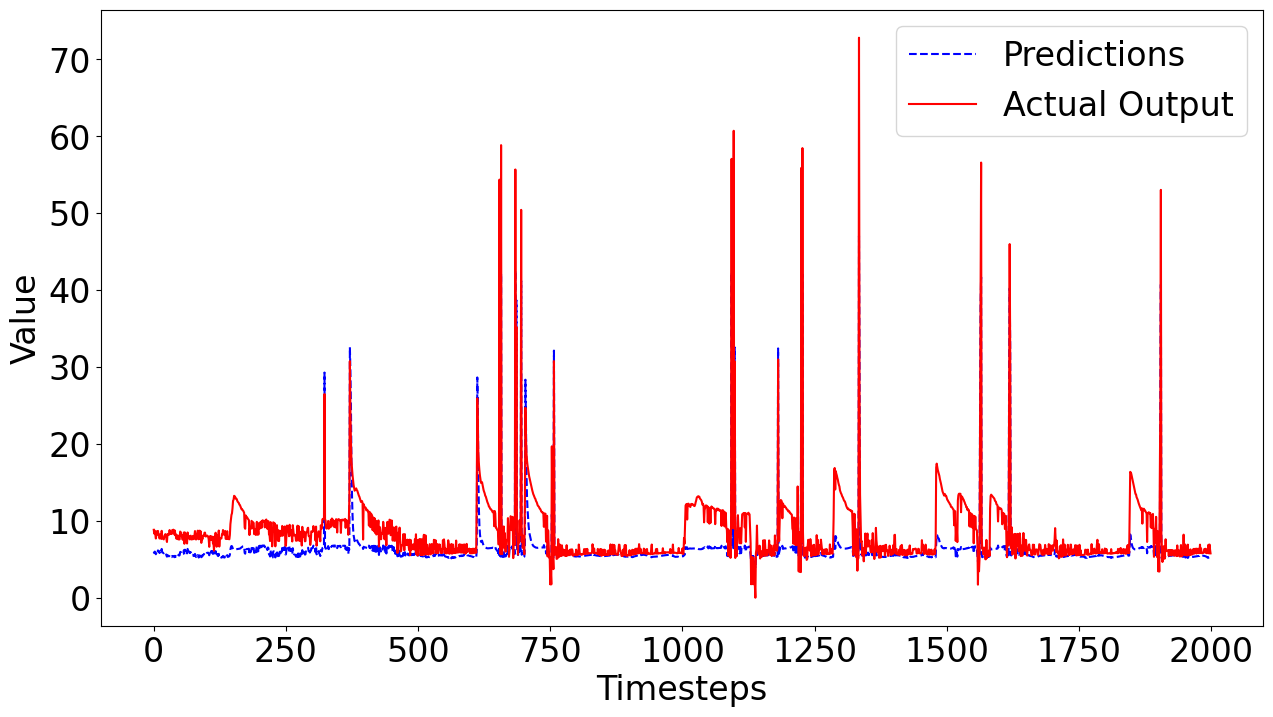

In [20]:
moe_model = load_model('/content/drive/Shareddrives/1st Paper/best_MoE_model_s7_0.h5')

# Load the test data
test_data = np.array(df[10000:12000])

# Split the test data into input and output sequences
test_input = test_data[:, :]
test_output = test_data[:, -1:]

# Normalize the input data (use the same normalization parameters as the training set)
test_input = (test_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)

test_predictions = moe_model.predict(test_input)

mae = mean_absolute_error(test_output, test_predictions)
mse = mean_squared_error(test_output, test_predictions)
print(f"Model performance on test set: MAE={mae}, MSE={mse}")

import matplotlib.pyplot as plt

# Set the font size for both the legend and axis numbers
legend_font_size = 24
axis_font_size = 24

# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.plot(test_predictions , color = 'blue', label='Predictions', linestyle='--')
plt.plot(test_output, color = 'red', label='Actual Output')

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size)

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Timesteps', fontsize=axis_font_size)
plt.ylabel('Value', fontsize=axis_font_size)

# Display the plot
plt.show()

In [ ]:
study.best_params

{'dropout_rate': 0.11427448714464156,
 'learning_rate': 0.0016783668118975344,
 'activation': 'tanh',
 'kernel_initializer': None}

In [ ]:
# retrieve the best hyperparameters
best_params = {'dropout_rate': 0.11427448714464156,
 'learning_rate': 0.0016783668118975344,
 'activation': 'tanh',
 'kernel_initializer': None}


# Train the model with the best hyperparameters


# Load the training data
train_data = np.array(df.head(10000))


# Split the training data into input and output sequences
train_input = train_data[:, :]
print('train_input shape', train_input.shape)
train_output = train_data[:, -1:]
print('train_output shape', train_output.shape)

# Define the input and output dimensions
input_dim = df.shape[1]
output_dim = 1

# Define the number of experts
num_experts = 3

# Define the sizes of the hidden layers for each expert
expert_hidden_sizes = [16, 32, 64]

# Define the sizes of the output layers for each expert
expert_output_sizes = [144,144,144]

# Define the sizes of the gating network hidden layers
gating_hidden_sizes = [16, 8]

# Define the size of the output layer of the gating network
gating_output_size = num_experts

# Define the number of training iterations for the EM algorithm
num_iterations = 300

# Define the optimization algorithm
optimizer =  SGD(learning_rate=best_params["learning_rate"], momentum=0.9)

# Learning rate scheduler
lr_scheduler = LearningRateScheduler(scheduler)


moe_model, experts, gating_model = build_moe_model_with_autoencoder_cnn_attention(
    input_dim,
    output_dim,
    expert_hidden_sizes,
    expert_output_sizes,
    gating_hidden_sizes,
    num_experts,
    best_params["learning_rate"],
    best_params["activation"],
    best_params["kernel_initializer"],
    best_params["dropout_rate"])


all_trainable_variables = []
for expert in experts:
    all_trainable_variables.extend(expert.trainable_variables)
all_trainable_variables.extend(gating_model.trainable_variables)
optimizer.build(all_trainable_variables)


# Train the MoE model with the EM algorithm
iteration = 0
while iteration < num_iterations:

    # E step: Compute the responsibilities of each expert for each data point
    gating_output = tf.constant(gating_model.predict(train_input), dtype=tf.float64)
    gating_output /= tf.reduce_sum(gating_output, axis=-1, keepdims=True) + 1e-8  # Add a small epsilon value

    # M step: Update the parameters of each expert and the gating network
    for i in range(num_experts):
        expert_input = train_input
        expert_output = experts[i](expert_input)
        expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        with tf.GradientTape() as tape:
            # Watch the trainable variables of the expert model
            tape.watch(experts[i].trainable_variables)

            # Define the expert model and calculate the expert_loss
            expert_output = experts[i](expert_input)
            expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        # Compute the gradients
        expert_gradient = tape.gradient(expert_loss, experts[i].trainable_variables)
        # Clip gradients for expert models
        expert_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in expert_gradient]

        # Update the variables
        optimizer.apply_gradients(zip(expert_gradient, experts[i].trainable_variables))
    
    current_learning_rate = scheduler(iteration, optimizer.learning_rate.numpy())
    optimizer.learning_rate.assign(current_learning_rate)

    gating_input = train_input

    with tf.GradientTape() as tape:
        # Watch the trainable variables of the gating model
        tape.watch(gating_model.trainable_variables)

        # Define the gating model and calculate the gating_loss
        gating_output = gating_model(gating_input)
        gating_loss = moe_loss(tf.constant(train_output, dtype=tf.float32), moe_model(train_input), gating_output)


    # Compute the gradients
    gating_gradient = tape.gradient(gating_loss, gating_model.trainable_variables)
    # Clip gradients for the gating model
    gating_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gating_gradient]

    # Update the variables
    optimizer.apply_gradients(zip(gating_gradient, gating_model.trainable_variables))

    # Evaluate the performance of the MoE model on the training set
    train_loss = moe_loss(train_output, moe_model.predict(train_input), gating_model.predict(train_input))


    print('Iteration %d: Training loss = %.6f' % (iteration + 1, train_loss))

    # Stop training if the learning rate becomes too small
    if current_learning_rate < 1e-8:
        print('Learning rate dropped below 1e-6 after iteration %d' % iteration)
        break

    iteration += 1

moe_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

moe_model.save('moe_models7.h5')
gating_model.save('gating_models7.h5')
for i, expert in enumerate(experts):
    expert.save(f'experts7_{i}.h5')


train_input shape (10000, 2)
train_output shape (10000, 1)
313/313 [==============================] - 1s 2ms/step


313/313 [==============================] - 0s 1ms/step
Iteration 1: Training loss = 332.172455
313/313 [==============================] - 0s 1ms/step
Iteration 2: Training loss = 1644.292969
313/313 [==============================] - 0s 1ms/step
Iteration 3: Training loss = 4316.527344
313/313 [==============================] - 0s 1ms/step
Iteration 4: Training loss = 4304.595215
313/313 [==============================] - 1s 2ms/step
Iteration 5: Training loss = 2120.437500
313/313 [==============================] - 0s 1ms/step
Iteration 6: Training loss = 372.922760
313/313 [==============================] - 0s 1ms/step
Iteration 7: Training loss = 376.448853
313/313 [==============================] - 1s 2ms/step
Iteration 8: Training loss = 2368.228271
313/313 [==============================] - 1s 2ms/step
Iteration 9: Training loss = 2708.667725
313/313 [==============================] - 0s 1ms/step
Iteration 10: Training loss = 6259.174316
313/313 [==============================] -